In [1]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import datetime as dt
from scipy import signal 
import holidays
import os
import sys
sys.path.append('../lib/')
from utils import *
from analysis import * 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', 
                   skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 
             'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + 
                               Electric['Hour'].astype(str) + ':' + 
                               Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [3]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


## Data Denoising

In [4]:
wave = 'coif5'
threshold = 0.01
Load_denoised = wavelet_filter(Electric.Load.to_numpy(), wavelet=wave, threshold=threshold)

Electric['Load_denoised'] = Load_denoised

Electric

,Date,Load,Minutes,Hour,Load_denoised
0,2008-01-01 00:15:00,15938.8,15,0,15928.858462
1,2008-01-01 00:30:00,15770.4,30,0,15773.991327
2,2008-01-01 00:45:00,15766.3,45,0,15773.305159
3,2008-01-01 01:00:00,15415.2,0,1,15443.517716
4,2008-01-01 01:15:00,15351.8,15,1,15381.987865
...,...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23,16035.903016
315644,2016-12-31 23:15:00,15865.3,15,23,15950.652000
315645,2016-12-31 23:30:00,15693.5,30,23,15785.417942
315646,2016-12-31 23:45:00,15508.3,45,23,15618.164303


### Residual histogram

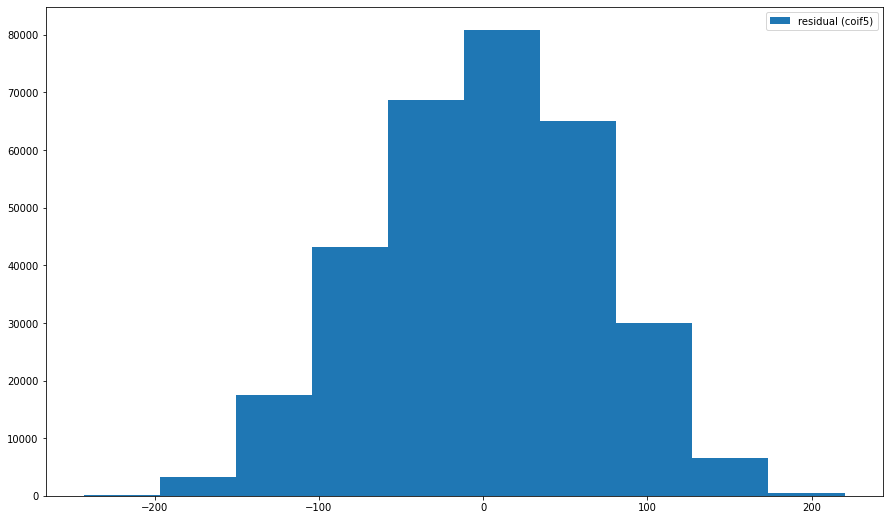

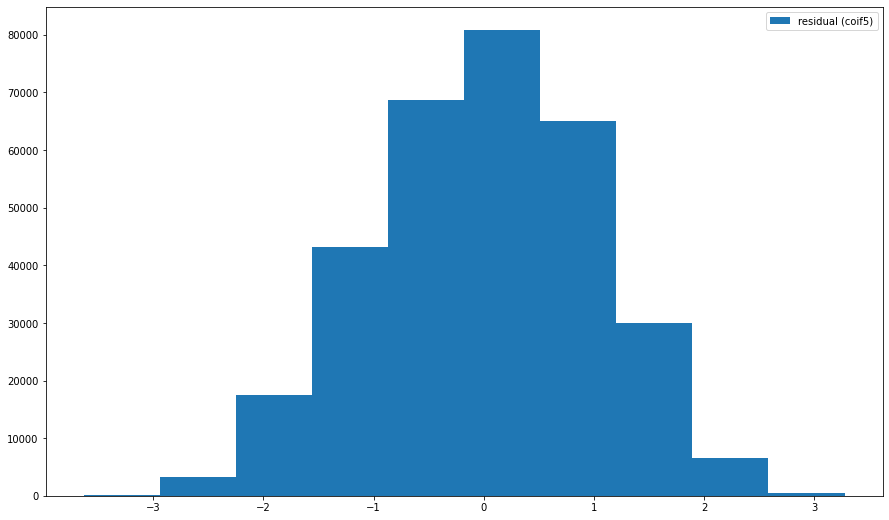

In [5]:
from scipy.stats import zscore

plt.figure(figsize=(15, 9))
plt.hist(Electric.Load.to_numpy() - Load_denoised, label=f'residual ({wave})')
plt.legend()
plt.show()

x = Electric.Load.to_numpy() - Load_denoised
z_score = zscore(x)


plt.figure(figsize=(15, 9))
plt.hist(z_score, label=f'residual ({wave})')
plt.legend()
plt.show()

In [6]:
from statsmodels.stats.diagnostic import kstest_normal

print(kstest_normal(x=Electric.Load.to_numpy() - Load_denoised, dist='norm', pvalmethod='table'))

kstest_normal(x=z_score)

(0.019531159490718597, 0.0009999999999998899)


(0.019531159490718597, 0.0009999999999998899)

<AxesSubplot:>

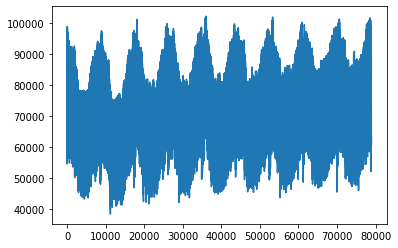

In [5]:
df = resampling_data(Electric, resample_cost='h')

df = df[~df.Load.isna()].reset_index(drop=True)
df['Load'].plot()

In [6]:
seasonal_comp = fourierExtrapolation(
    df.Load.to_numpy(),
    int(0),
    n_harm=10)


df['Load_lin_seasonal'] = linear_fit(x=df.index, y=df.Load) + seasonal_comp
df['Load_real_comp'] = df.Load - df['Load_lin_seasonal']

df

,Date,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin_seasonal,Load_real_comp
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1,76289.838217,-15469.938217
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1,76290.338776,-18420.538776
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1,76290.836251,-20618.036251
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1,76291.330643,-20959.630643
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1,76291.821951,-21764.821951
...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366,82543.526730,-12153.226730
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366,82544.042702,-15618.942702
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366,82544.555592,-17644.455592
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366,82545.065399,-19525.265399


In [10]:
df.add(df['Load_lin_seasonal'], axis=1)

In [31]:
def add_linear_seasonal_terms(df, new_col='Load', signal_col='Load_real_comp', lin_col='Load_lin_seasonal'):
    """Lin_column must be the first column.

    Args:
        df (_type_): _description_
        lin_column (str, optional): _description_. Defaults to 'Load_lin'.
    """
    for column in df.columns:
        df[column] += df[lin_col]
    
    del df[lin_col]
    df.columns = df.columns.str.replace(signal_col, new_col)

    return df


def psf_forecasting(df, cut_day='2016-12-22', feature='Load_real_comp'):
    train_set = df[df.Date < pd.to_datetime(cut_day, format='%Y-%m-%d')].copy()
    test_set = df[df.Date >= pd.to_datetime(cut_day, format='%Y-%m-%d')].copy()
    n_days_ahead = len(test_set.Date.dt.day_of_year.unique())
    
    working_days = train_set[~train_set.Holiday].reset_index(drop=True)
    festivities = train_set[train_set.Holiday].reset_index(drop=True)
    
    f = {feature: ['mean', q1, q2], 'Load_lin_seasonal': ['mean', q1, q2]}
    pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
    pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)    

    forecasting = []
    for day in pd.date_range(cut_day, periods=n_days_ahead, freq="d"):
        if any(day.day_of_year == festivities['Day id']):
            forecasting.append(pred_festivities.loc[day.day_of_year][feature].to_numpy())
        else:
            forecasting.append(pred_working_days.loc[day.day_of_week][feature].to_numpy())

    forecasting = np.concatenate(forecasting)
    
    tmp = df[['Date', 'Load_lin_seasonal', feature]].copy()
    n = len(forecasting) - len(test_set)

    tmp.loc[tmp.Date > cut_day,
            ['forecast', 'q1_forecast', 'q2_forecast']] = forecasting[:-n-1, :]
    tmp.set_index('Date', inplace=True)

    return add_linear_term(tmp)

In [32]:
def plot_model_forecasting(df, cut_day, model, feature = 'Load'):
   
    freq = df.index.inferred_freq 
    if freq == 'W-SUN':
        weeks = 52
        n_weeks = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days // 7
        time_interval = n_weeks
        interval_type = 'weeks'     
    else:
        weeks = 2
        n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days
        time_interval = n_days
        interval_type = 'days'
        
    date = pd.to_datetime(cut_day) - dt.timedelta(weeks=weeks)
    cut_mask = df.index >= cut_day
    date_mask = df.index > date
 
    ax = latex_settings()
    df.loc[date_mask, [feature]].plot(ax=ax, color='b', lw=1)
    df.loc[cut_mask, [feature, 'forecast']].plot(ax=ax, color=['g', 'orange'], lw=1)
    ax.fill_between(x=df[date_mask].index, y1=df[date_mask].q1_forecast,
                    y2=df[date_mask].q2_forecast, color='orange', alpha=0.5, lw=1)
    ax.grid()
    ax.set_ylabel('Load (MW)')
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_title(f'Poland Electricity Load ({time_interval} {interval_type})')
    leg = plt.legend(loc="lower left", ncol=4, fancybox=True, framealpha=0.5,
                     fontsize=7.5,
                     labels=['Train set', 'Test set', 'Forecast', '95% CI'])

    file_path = f'../Images/{model}/'
    file = f'{model}_{freq}_{time_interval}{interval_type}.png'
    if os.path.isfile(file_path + file):
        pass
    else:    
        df.to_csv(file_path + file, index=True)
    
    plt.savefig(file_path + file, dpi=800, transparent=True)

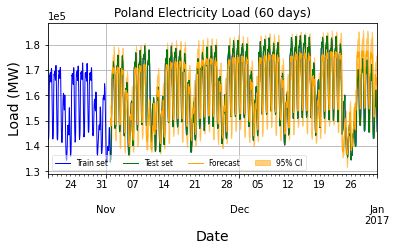

In [121]:
cut_dates = ['2016-11-02']#['2016-12-25', '2016-12-02', '2016-11-02', '2016-10-03'] 

#dfs = []
for cut_date in cut_dates:
    tmp = psf_forecasting(df, cut_day=cut_date)
    plot_model_forecasting(tmp, cut_date, model='PSF')
    dfs.append(tmp)

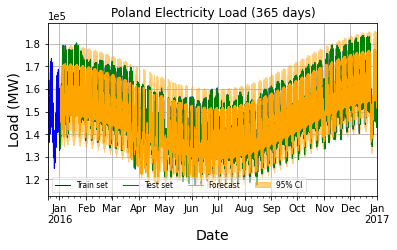

In [119]:
cut_dates = ['2016-01-02']#['2016-07-05', '2016-09-03', '2016-08-04'] 


for cut_date in cut_dates:
    tmp = psf_forecasting(df, cut_day=cut_date)
    plot_model_forecasting(tmp, cut_date, model='PSF')
    dfs.append(tmp)

In [122]:
for i in range(len(dfs)):
    mask = dfs[i].forecast.notna()
    tmp = dfs[i][mask].copy()

    mask_ci = (tmp['q1_forecast'] <= tmp['Load']) & (tmp['Load'] <= tmp['q2_forecast'])

    print(len(tmp[mask_ci]) / len(tmp))

0.6972222222222222
0.7213888888888889
0.7391518737672583
0.7456018518518519
0.08208105646630237
0.7456018518518519
0.6832718327183271
0.7086791147994468
0.7293650793650793
0.7456018518518519
0.7086791147994468
0.8122240618101545
0.8102970795568983
0.796731123388582
0.7964876033057852
0.08208105646630237
0.795662100456621
0.3630952380952381
0.6097222222222223
0.795662100456621
0.6333333333333333


In [111]:
file_path = "../Results/PSF/"
days = [7, 30 , 60, 90, 120, 150]

for df1, day in zip(dfs, days):
    freq = df1.index.inferred_freq
    file = f"PSF_{freq}_{day}days.csv"
    df1[df1.forecast.notna()].to_csv(file_path+file, index=True)

In [132]:
i = 3

mask = dfs[i].forecast.notna()

dfs[i][mask]

,Load,forecast,q1_forecast,q2_forecast
Date,,,,
2016-07-05 01:00:00,130400.474530,131443.233295,121056.709650,136680.163860
2016-07-05 02:00:00,128420.552189,129375.020067,119698.971524,134905.982291
2016-07-05 03:00:00,128652.532695,128457.283707,119695.333082,133583.035831
2016-07-05 04:00:00,127648.516047,128658.954399,120081.154006,133476.435327
2016-07-05 05:00:00,127873.602246,128877.216706,120816.321412,133314.360756
...,...,...,...,...
2016-12-31 20:00:00,152878.429675,167053.586908,159615.445117,174518.826624
2016-12-31 21:00:00,149413.641169,166785.109648,161460.609318,172021.748006
2016-12-31 22:00:00,147389.049624,164402.261854,159879.229287,168539.425483
